https://www.kaggle.com/code/sudhanshu2198/multi-class-credit-score-classification

# Importing libraries

In [42]:
import numpy as np 
import pandas as pd
from scipy import stats as st
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from xgboost import XGBClassifier
!pip install lightgbm
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
!pip install optuna
import optuna
import json
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid")

In [43]:
import warnings
warnings.filterwarnings("ignore")

# Data Visualization

In [6]:
data = pd.read_csv("C:/Users/DELL-PC/Desktop/PGDM/Term 5/DL & ML/End Term Project/sdf/Score.csv")

In [27]:
data.head()

Delay_from_due_date  Num_of_Delayed_Payment  Num_Credit_Inquiries  \
0                  3.0                     7.0                   4.0   
1                  3.0                     7.0                   4.0   
2                  3.0                     7.0                   4.0   
3                  5.0                     4.0                   4.0   
4                  6.0                     4.0                   4.0   

   Credit_Utilization_Ratio  Credit_History_Age Payment_of_Min_Amount  \
0                 26.822620               265.0                    No   
1                 31.944960               265.0                    No   
2                 28.609352               267.0                    No   
3                 31.377862               268.0                    No   
4                 24.797347               269.0                    No   

   Amount_invested_monthly  Monthly_Balance Credit_Score Credit_Mix  ...  \
0                80.415295       312.494089         Good       Good  ...   
1               118.280222       284.629162         Good       Good  ...   
2                81.699521       331.209863         Good       Good  ...   
3               199.458074       223.451310         Good       Good  ...   
4                41.420153       341.489231         Good       Good  ...   

    Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  \
0  23.0       19114.12                3.0              4.0            3.0   
1  23.0       19114.12                3.0              4.0            3.0   
2  23.0       19114.12                3.0              4.0            3.0   
3  23.0       19114.12                3.0              4.0            3.0   
4  23.0       19114.12                3.0              4.0            3.0   

   Num_of_Loan  Monthly_Inhand_Salary  Changed_Credit_Limit  Outstanding_Debt  \
0          4.0            1824.843333                 11.27            809.98   
1          4.0            1824.843333                 11.27            809.98   
2          4.0            1824.843333                 11.27            809.98   
3          4.0            1824.843333                 11.27            809.98   
4          4.0            1824.843333                 11.27            809.98   

   Total_EMI_per_month  
0            49.574949  
1            49.574949  
2            49.574949  
3            49.574949  
4            49.574949  

[5 rows x 21 columns]

In [28]:
data.columns

Index(['Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Monthly_Balance',
       'Credit_Score', 'Credit_Mix', 'Payment_Behaviour', 'Age',
       'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Monthly_Inhand_Salary',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Total_EMI_per_month'],
      dtype='object')

In [7]:
X=data.drop("Credit_Score",axis=1)
y=data["Credit_Score"]

numeric=X.select_dtypes(exclude="object").columns
categorical=['Payment_of_Min_Amount', 'Credit_Mix']

low_cardinality=[col for col in numeric if data[col].nunique()<=30]
high_cardinality=[col for col in numeric if data[col].nunique()>30]

In [50]:
high_cardinality

['Delay_from_due_date',
 'Credit_Utilization_Ratio',
 'Credit_History_Age',
 'Amount_invested_monthly',
 'Monthly_Balance',
 'Age',
 'Annual_Income',
 'Interest_Rate',
 'Monthly_Inhand_Salary',
 'Changed_Credit_Limit',
 'Outstanding_Debt',
 'Total_EMI_per_month']

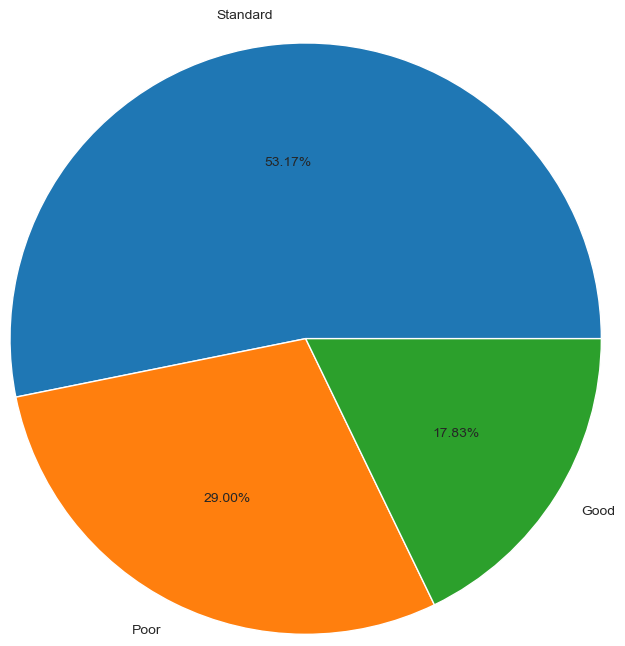

In [8]:
ser=data["Credit_Score"].value_counts()
plt.pie(x=ser.values, labels=ser.index, autopct="%0.2f%%", radius=2);
plt.savefig("image1.png")

#### There is unequal class distribution in target variable,but the difference ratio is not very high. we will test cost-sensitive learning on the dataset.

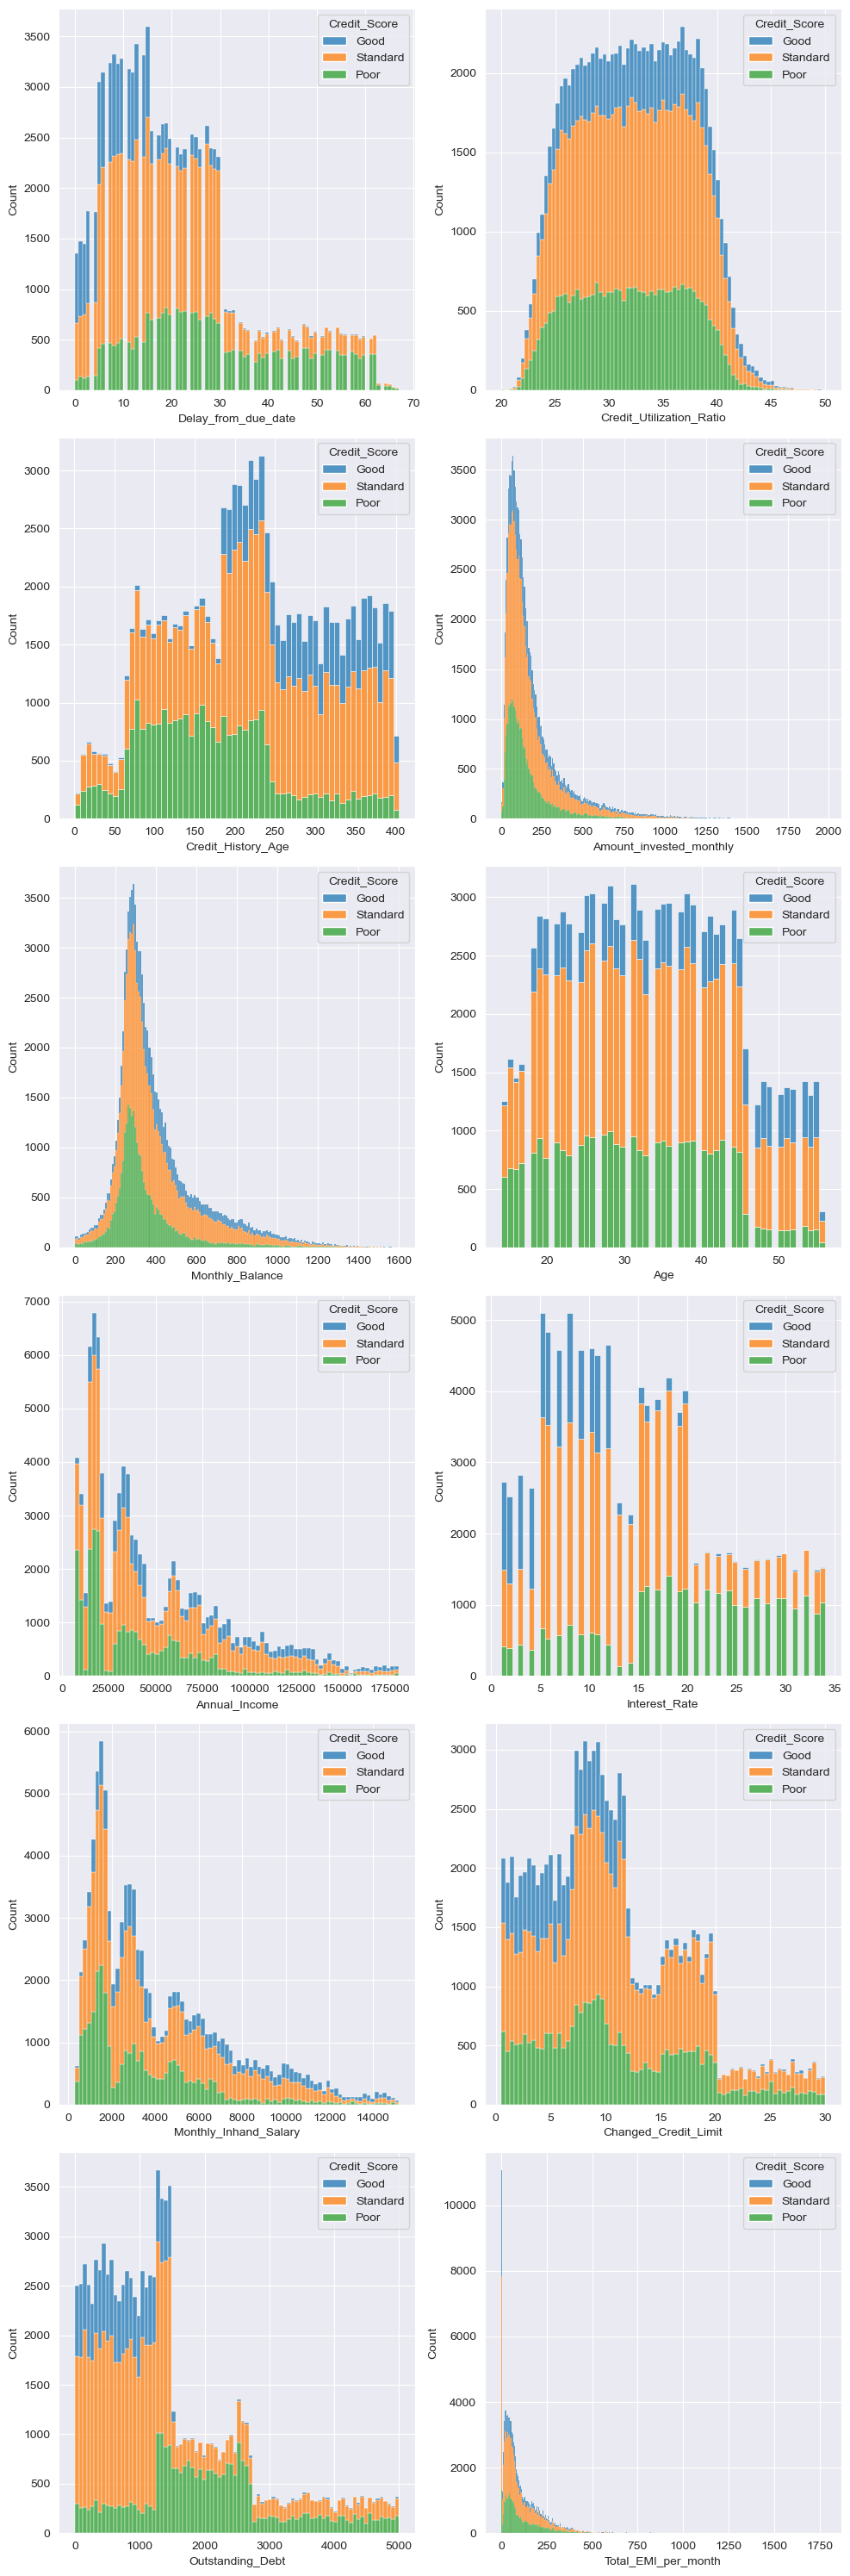

In [9]:
rows=[len(high_cardinality)//2 if len(high_cardinality)%2==0 else len(high_cardinality)//2+1]
fig,axes=plt.subplots(rows[0],2,figsize=(10,30))

ax=axes.flatten()
for i,col in enumerate(high_cardinality):
    sns.histplot(data=data,x=col,hue="Credit_Score",ax=ax[i],multiple="stack");
    
plt.tight_layout()
plt.savefig("image2.png")

#### Outstanding_Dedt,Interest_Rate,Delay_from_due_date as these variables value increases, the proportion of Bad Credit_Score instances increases substantially, while Standard and Good Credit_Score instances proportion become meagre.
#### On the other hand increase in Credit_History_Age, Age reults in decrease of Bad Credit_Score instances, jump in Standard and Good Credit_Score instance.
#### Interestingly credit_utilization_ratio seems to seems to have same distribution for all categories of credit score.
#### The distribution of many features have non-gaussian distribution and largely different scales, therefore we will tranform feature variables.

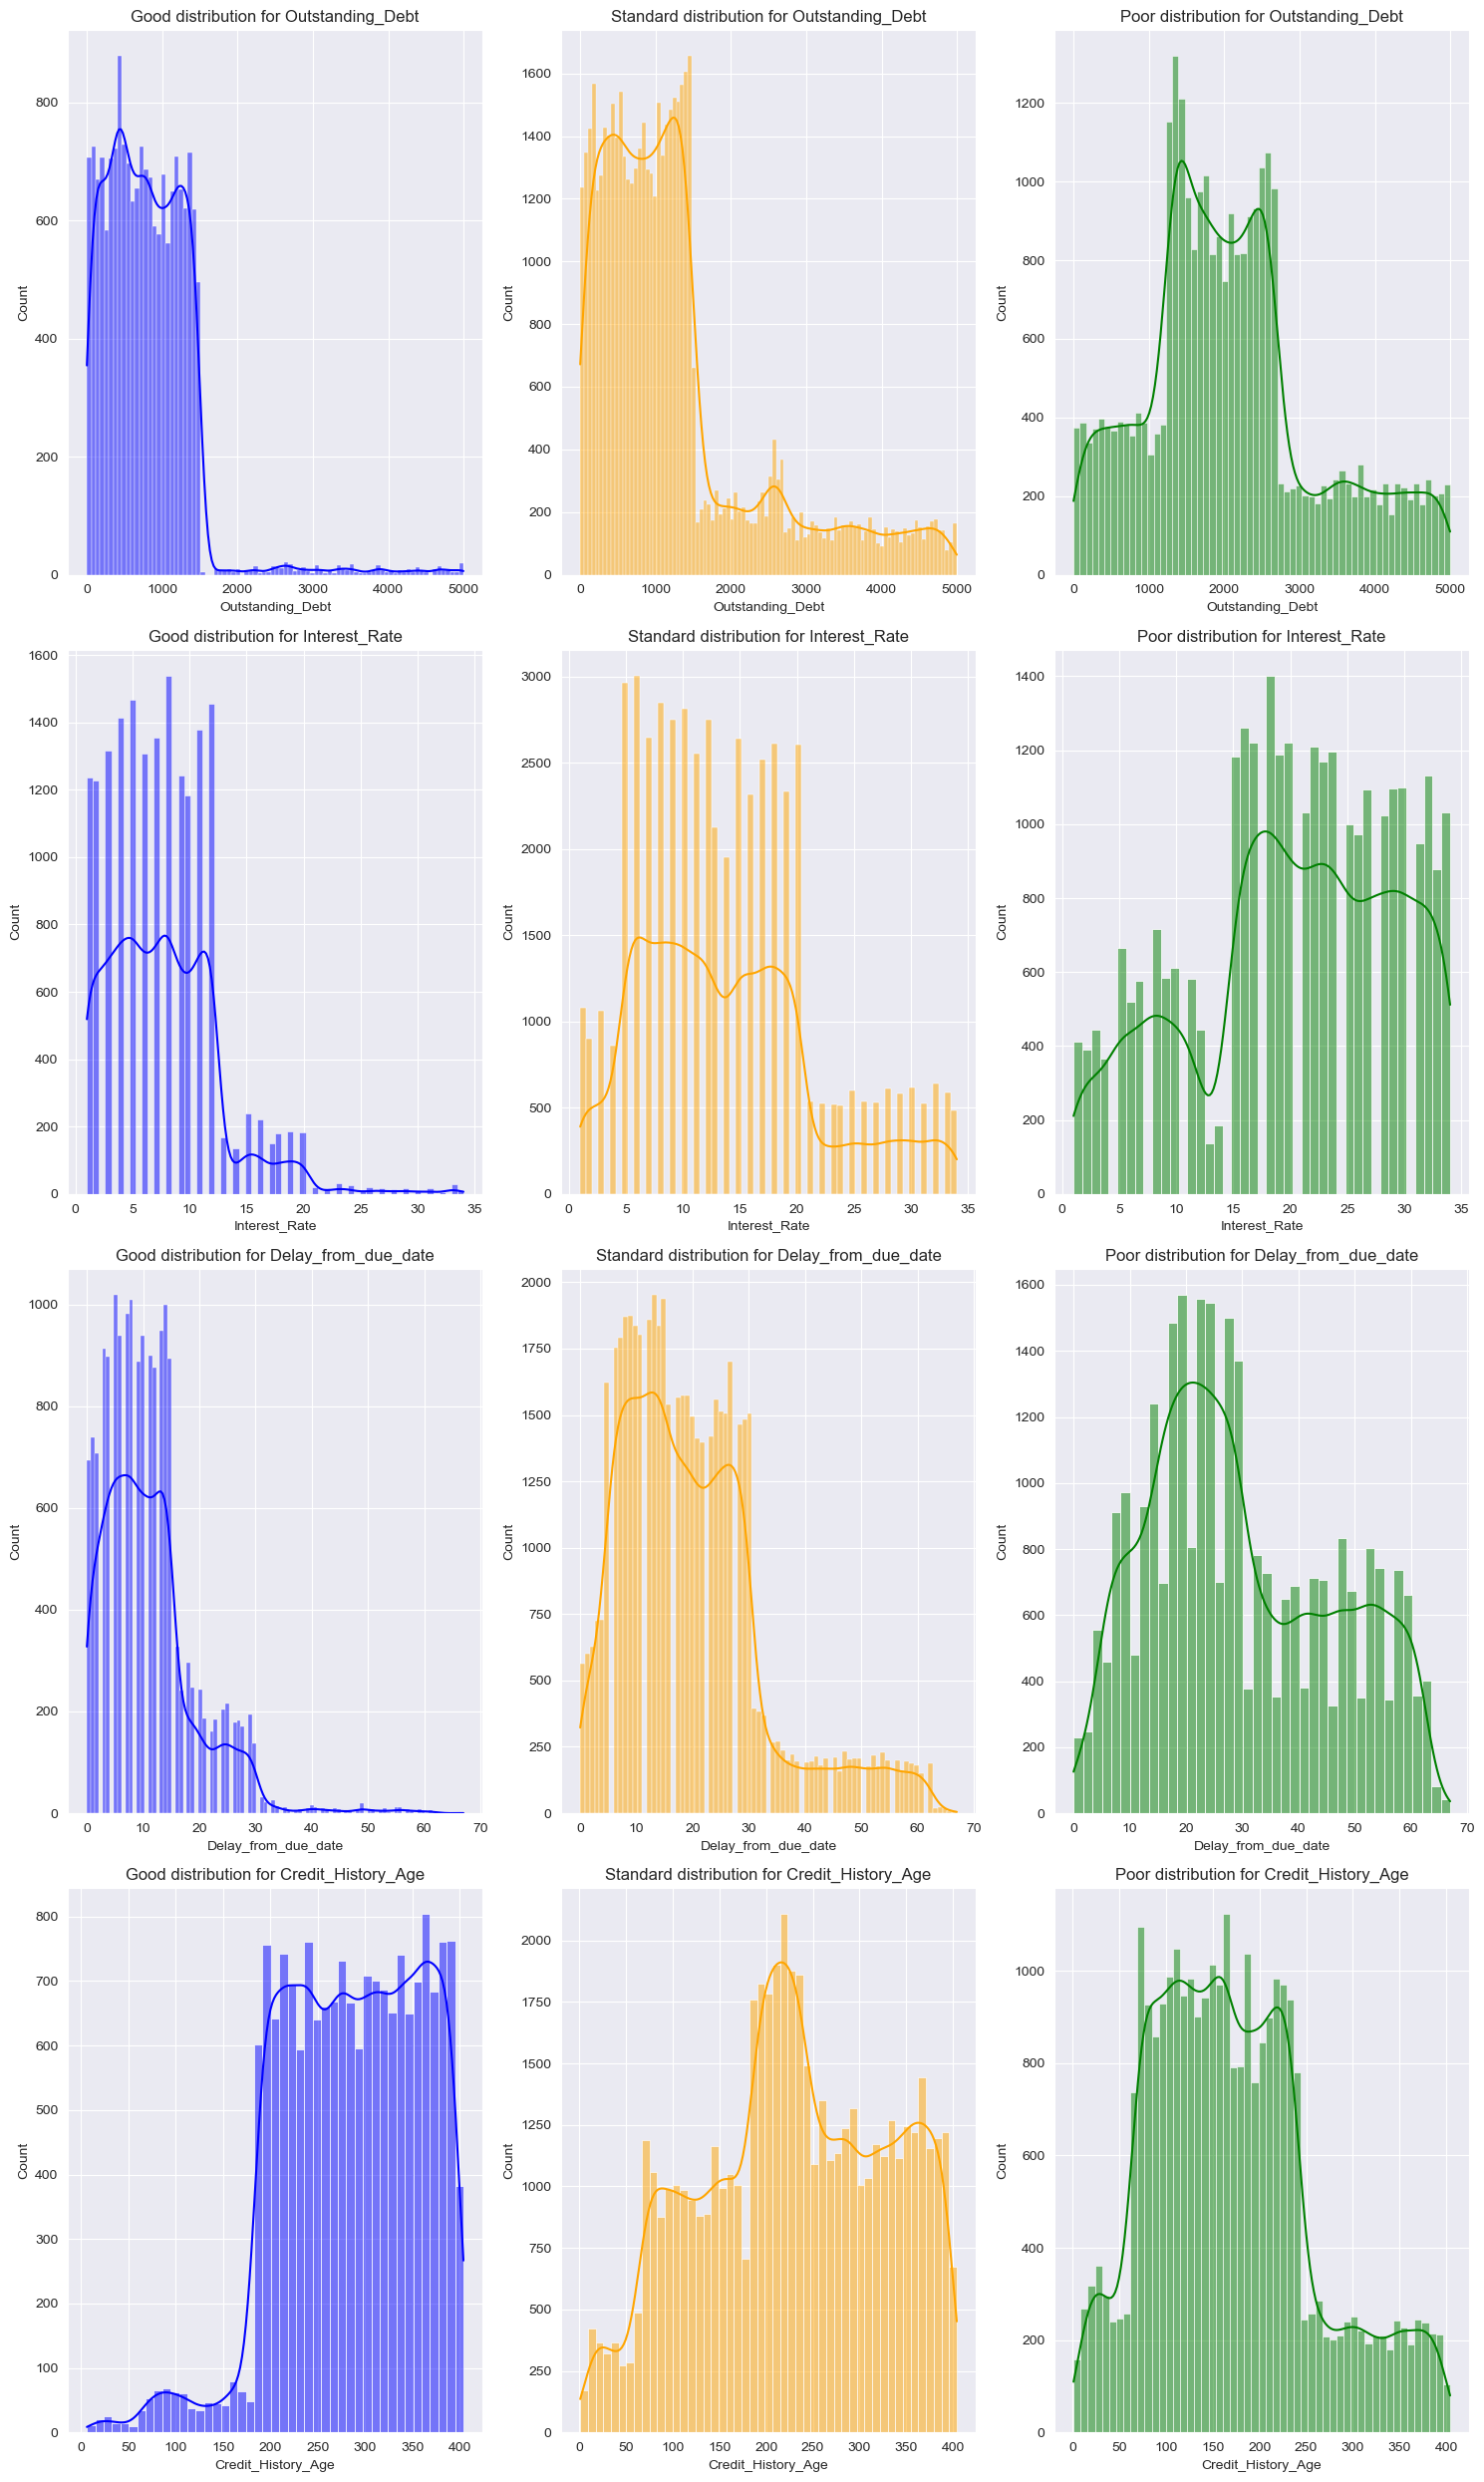

In [10]:
cols=["Outstanding_Debt", "Interest_Rate", "Delay_from_due_date", "Credit_History_Age"]
vals=["Good","Standard","Poor"]
colors=["blue","orange","green"]

fig,axes=plt.subplots(len(cols),3,figsize=(15,25))

for i,col in enumerate(cols):
    for j,(val,color) in enumerate(zip(vals,colors)):
        ax=axes[i,j]
        inter=data[data["Credit_Score"]==val]
        sns.histplot(data=inter,x=col,ax=ax,color=color,kde=True);
        ax.set_title(f"{val} distribution for {col}")
    
plt.tight_layout()
plt.savefig("image3.png")

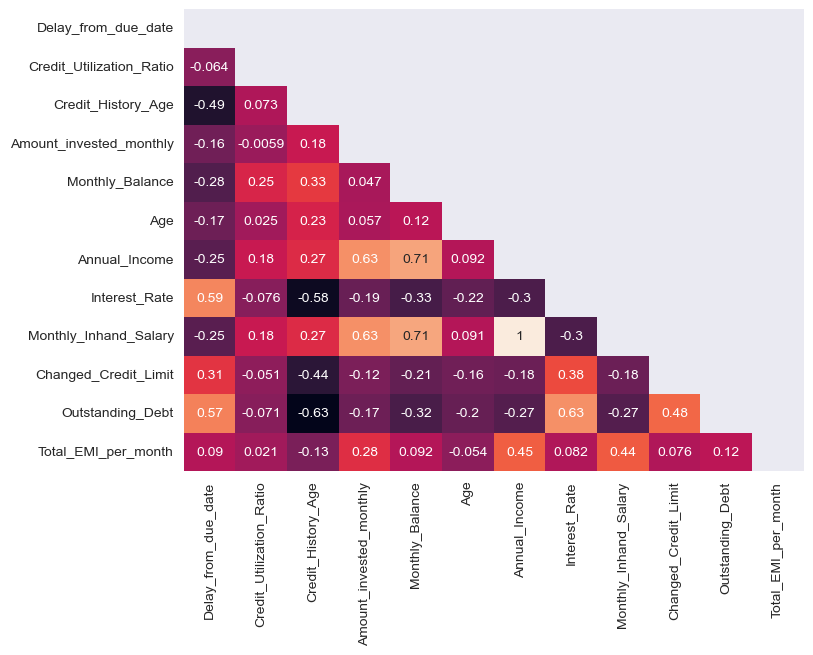

In [11]:
plt.figure(figsize=(8, 6))
arr=np.ones_like(data[high_cardinality].corr())
mask=np.triu(arr)
sns.heatmap(data[high_cardinality].corr(), cbar=False, annot=True, fmt=".2g", mask=mask);
plt.savefig("image4.png")

#### Many variable have strong correlation with others,for example Num_of_Delayed_Payment has strong positive correlation with interest_rate charged(0.57), outstanding_debt(0.50), delay_from_due_date (0.54), Num_Credit_Inquiries (0.50) and strong negative correlation with Credit_History_Age (-0.49) and Monthly_Inhand_Salary(-0.28).

#### A person who has taken large sum of money at high interest rate with less salary, financial discipline and savings are more likely to have high no of delayed payments, looking for more credit to pay off loans, ending up with high interest rate and large debt.

#### Credit_History_Age has strong negative correlation with Num_of_Delayed_Payment, Num_Credit_Inquiries, Interest_Rate, Outstanding_Debt.

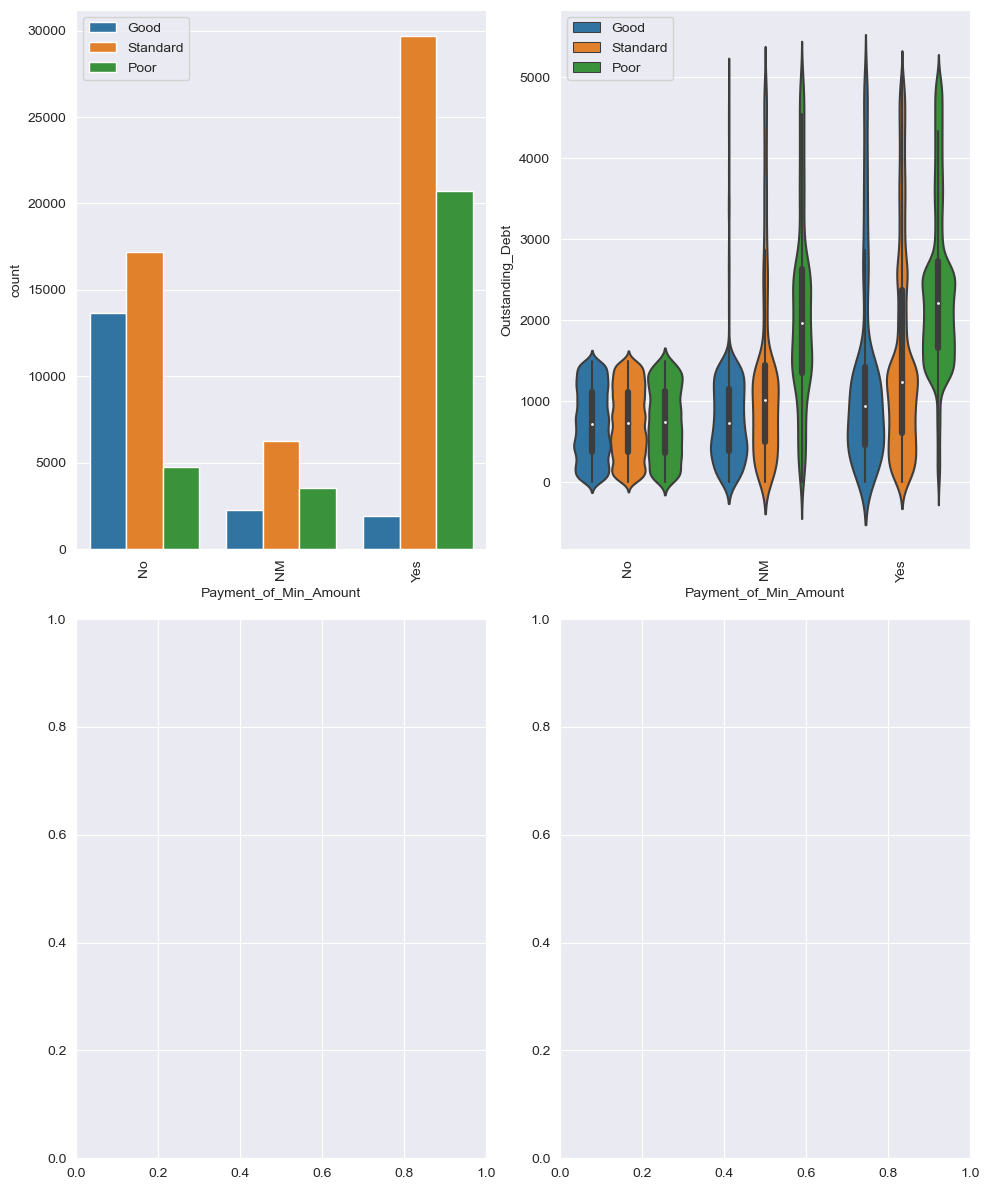

In [12]:
fig,axes=plt.subplots(2,2,figsize=(10,12))

for i,col in enumerate(categorical[:-1]):
    ax=axes[i,0]
    sns.countplot(x=data[col],hue=data["Credit_Score"],ax=ax)
    ax.set_xticklabels(labels=data[col].unique(),rotation=90)
    ax.legend()
    
    ax=axes[i,1]
    sns.violinplot(x=data[col],hue=data["Credit_Score"],y=data["Outstanding_Debt"],ax=ax)
    ax.set_xticklabels(labels=data[col].unique(),rotation=90)
    ax.legend()
    
plt.tight_layout()
plt.savefig("image5.png")

#### We can see Credit_Mix and Payment_of_Min_Amount influences the categories of Credit_Score
#### If someone has made Payment_of_Min_Amount, poor score have higher outstanding debt than standard and good debt, while if someone has not made Payment_of_Min_Amount then outstanding debt have no impact on credit score.

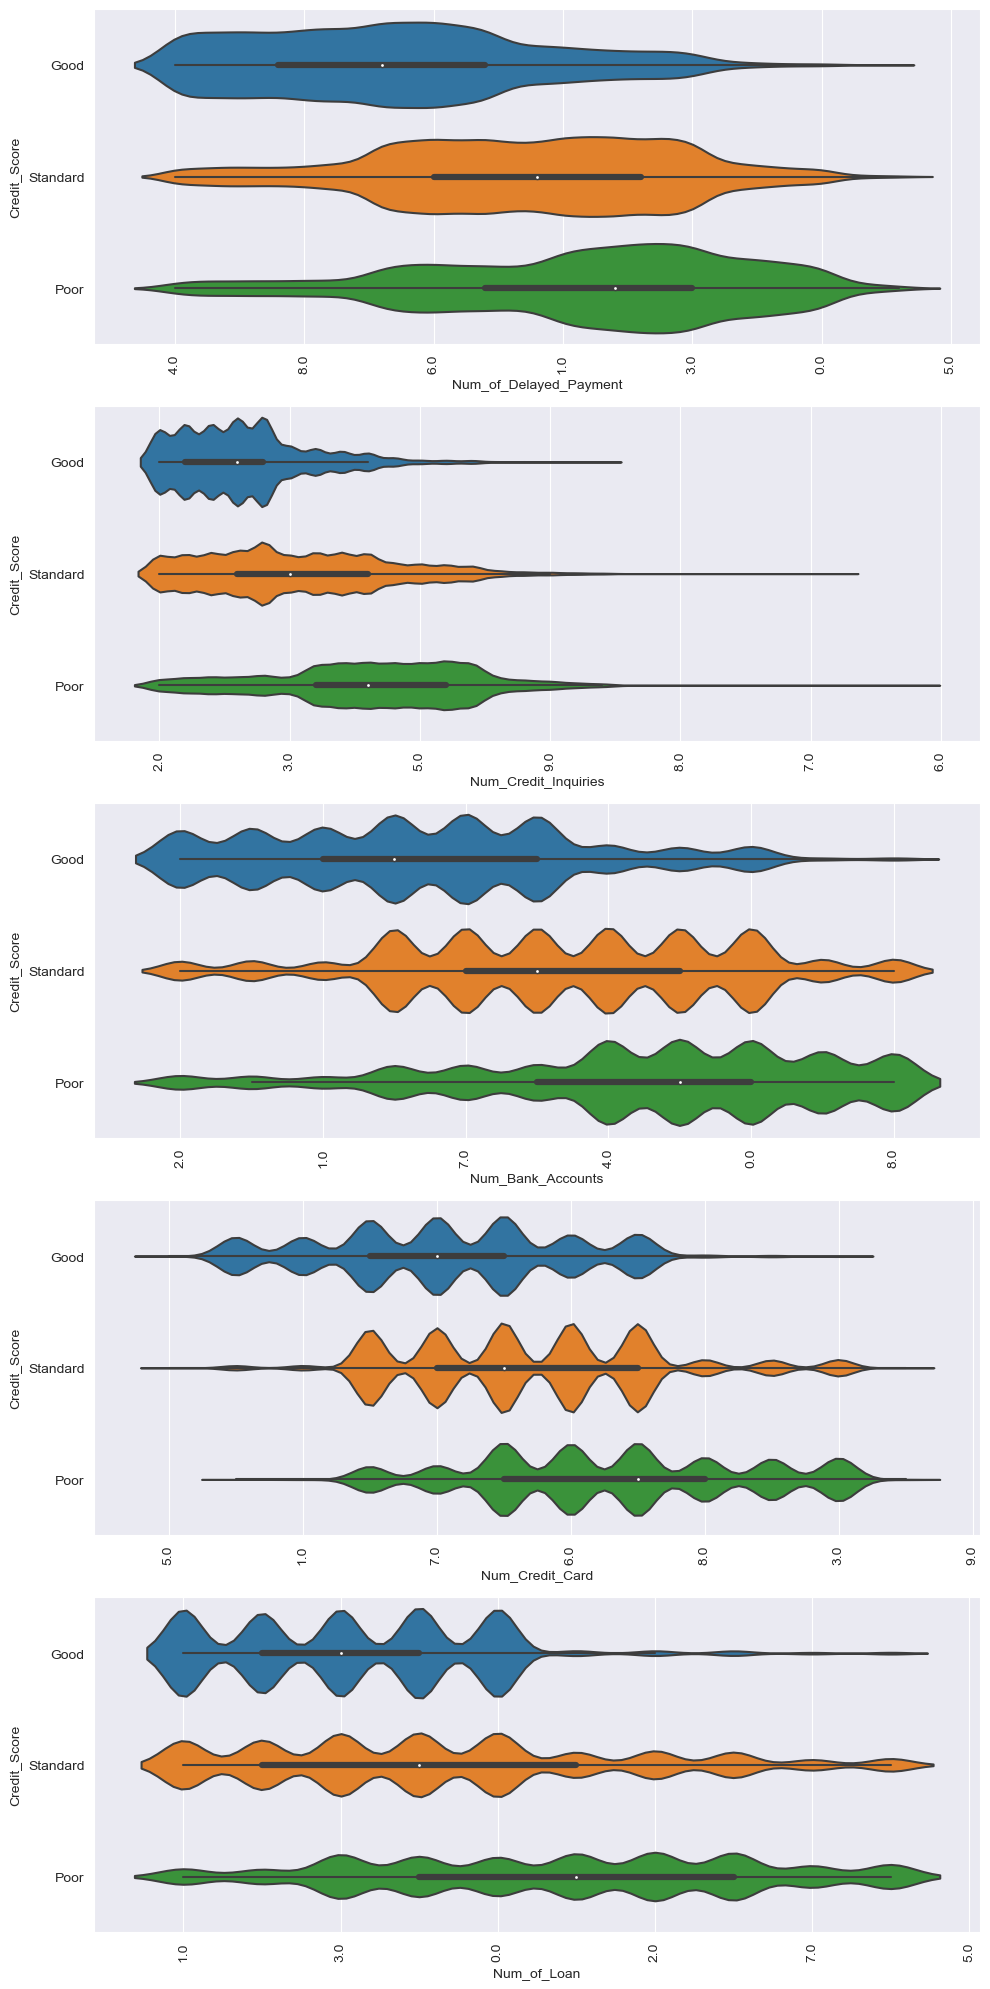

In [13]:
fig,axes=plt.subplots(5,figsize=(10,20))

for i,col in enumerate(low_cardinality):

    ax=axes[i]
    sns.violinplot(x=data[col],y=data["Credit_Score"],ax=ax);
    ax.set_xticklabels(labels=data[col].unique(),rotation=90)
    
plt.tight_layout()
plt.savefig("image6.png")

#### As the variables Num_of_Delayed_Payment, Num_Credit_Inquiries, Num_Bank_Accounts, Num_Credit_Card, Num_of_Loan values increases the proportion of poor credit scores increases, while good and standard credit scores instances were quite less.
#### Num_of_Delayed_Payment variable having the most visible effect.

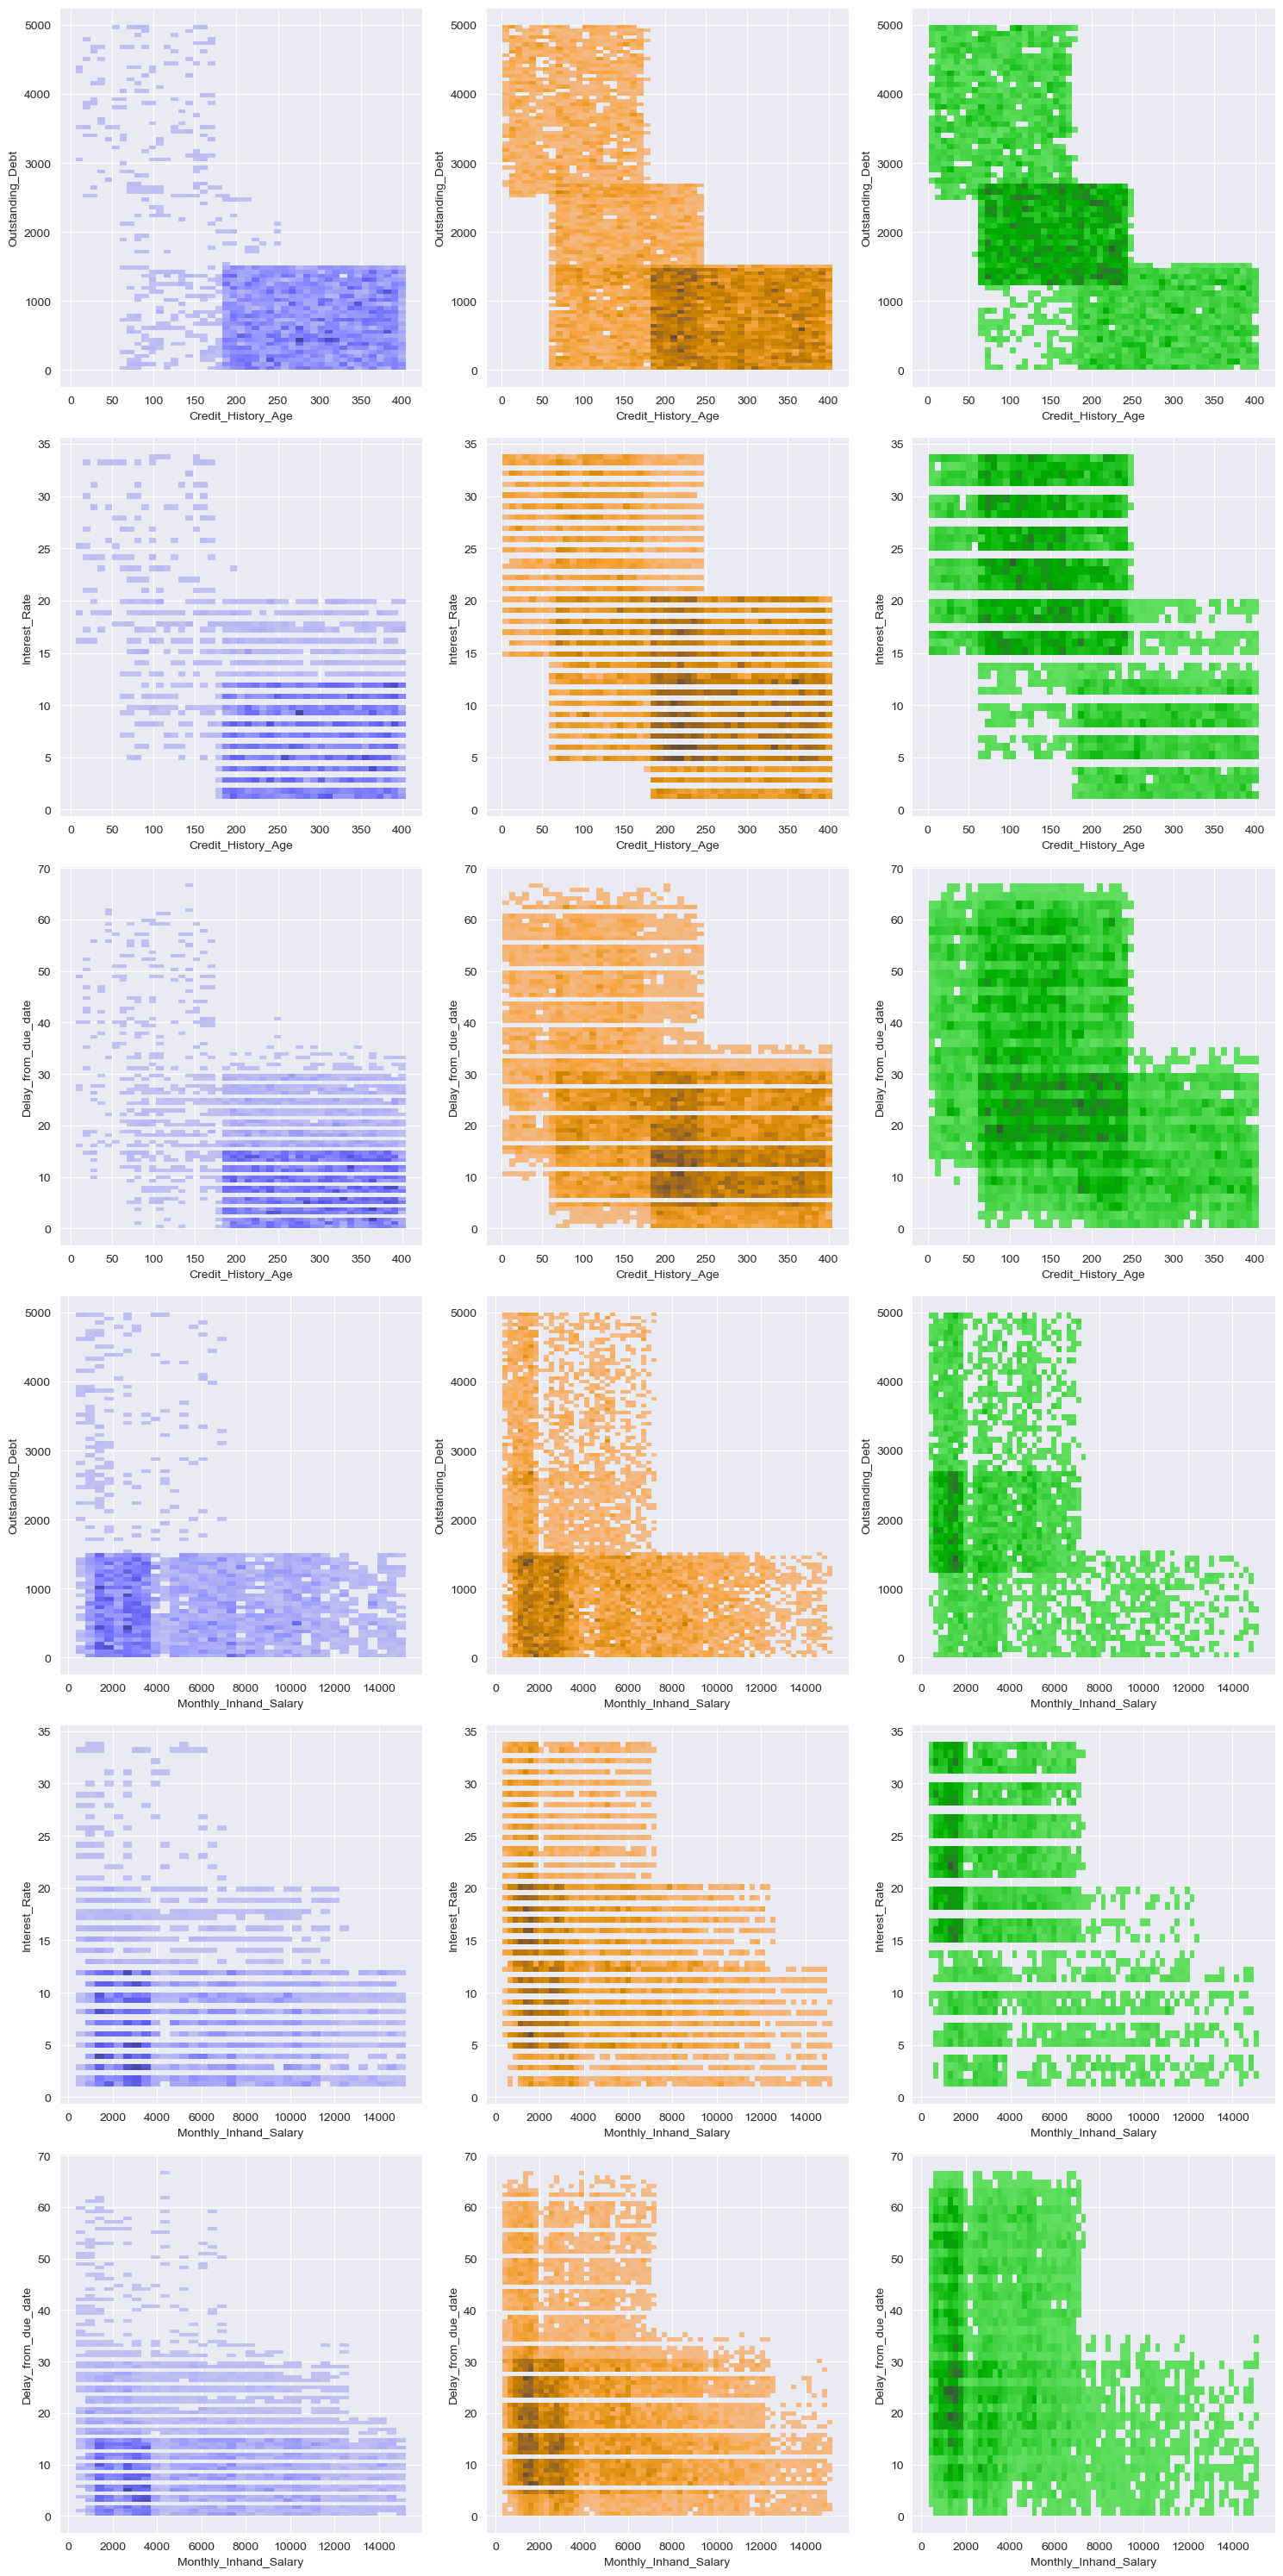

In [14]:
from itertools import product
arr1=["Credit_History_Age","Monthly_Inhand_Salary"]
arr2=["Outstanding_Debt","Interest_Rate","Delay_from_due_date"]

pairs=list(product(arr1,arr2))

fig,axes=plt.subplots(len(pairs),3,figsize=(15,30))

for i,(x,y) in enumerate(pairs):
    colors=["blue","orange","green"]
    vals=["Good","Standard","Poor"]
    for j,(color,val) in enumerate(zip(colors,vals)):
        ax=axes[i,j]
        inter=data[data["Credit_Score"]==val]
        sns.histplot(x=x,y=y,data=inter,color=color,ax=ax);
    
plt.tight_layout()
plt.savefig("image7.png")

#### Theses charts shows density distribution of credit scores categories using bivariate analysis.
#### Overlapping instances zones are places where instances are mostly misclassified, seeing the data ensemble based learning methods will be best, while linear models will be ineffective because of presence of complex non-linear relationship.SVM will be time consuming because of large dataset size, overlapping of instances

# Data Preprocessing

In [60]:
#label encoding target variable
label=LabelEncoder()
label.fit(data["Credit_Score"])
y=label.transform(data["Credit_Score"])


#Quantile Transformation (outputing data following a normal distribution)
transformer = QuantileTransformer(output_distribution='normal')
numeric = transformer.fit_transform(data[high_cardinality])

#one hot encoding 
encoding=OneHotEncoder(drop="first")
encoding.fit(data[categorical])
one_hot=encoding.transform(data[categorical]).toarray()

#ordinal variables
ordinal=data[low_cardinality].values

#Feature array
X=np.concatenate([numeric,one_hot,ordinal],axis=1)


#Feature array
X=np.concatenate([numeric,one_hot,ordinal],axis=1)

# Algorithm Spot Checking

In [61]:
def get_models():
    names,models=[],[]
    
    models.append(RandomForestClassifier(random_state=42,n_jobs=-1))
    names.append("RandomForestClassifier")
    
    models.append(XGBClassifier(random_state=42,n_jobs=-1))
    names.append("XGBClassifier")
    
    models.append(LGBMClassifier(random_state=42,n_jobs=-1))
    names.append("LGBMClassifier")
    
    return names,models

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 79968, number of used features: 21
[LightGBM] [Info] Start training from score -1.724308
[LightGBM] [Info] Start training from score -1.237862
[LightGBM] [Info] Start training from score -0.631676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2532
[LightGBM] [Info] Number of data points in the train set: 79968, number of used features: 21
[LightGBM] [Info] Start training from score -1.724308
[LightGBM] [Info] Start training from score -1.237862
[LightGBM] [Info] Start 

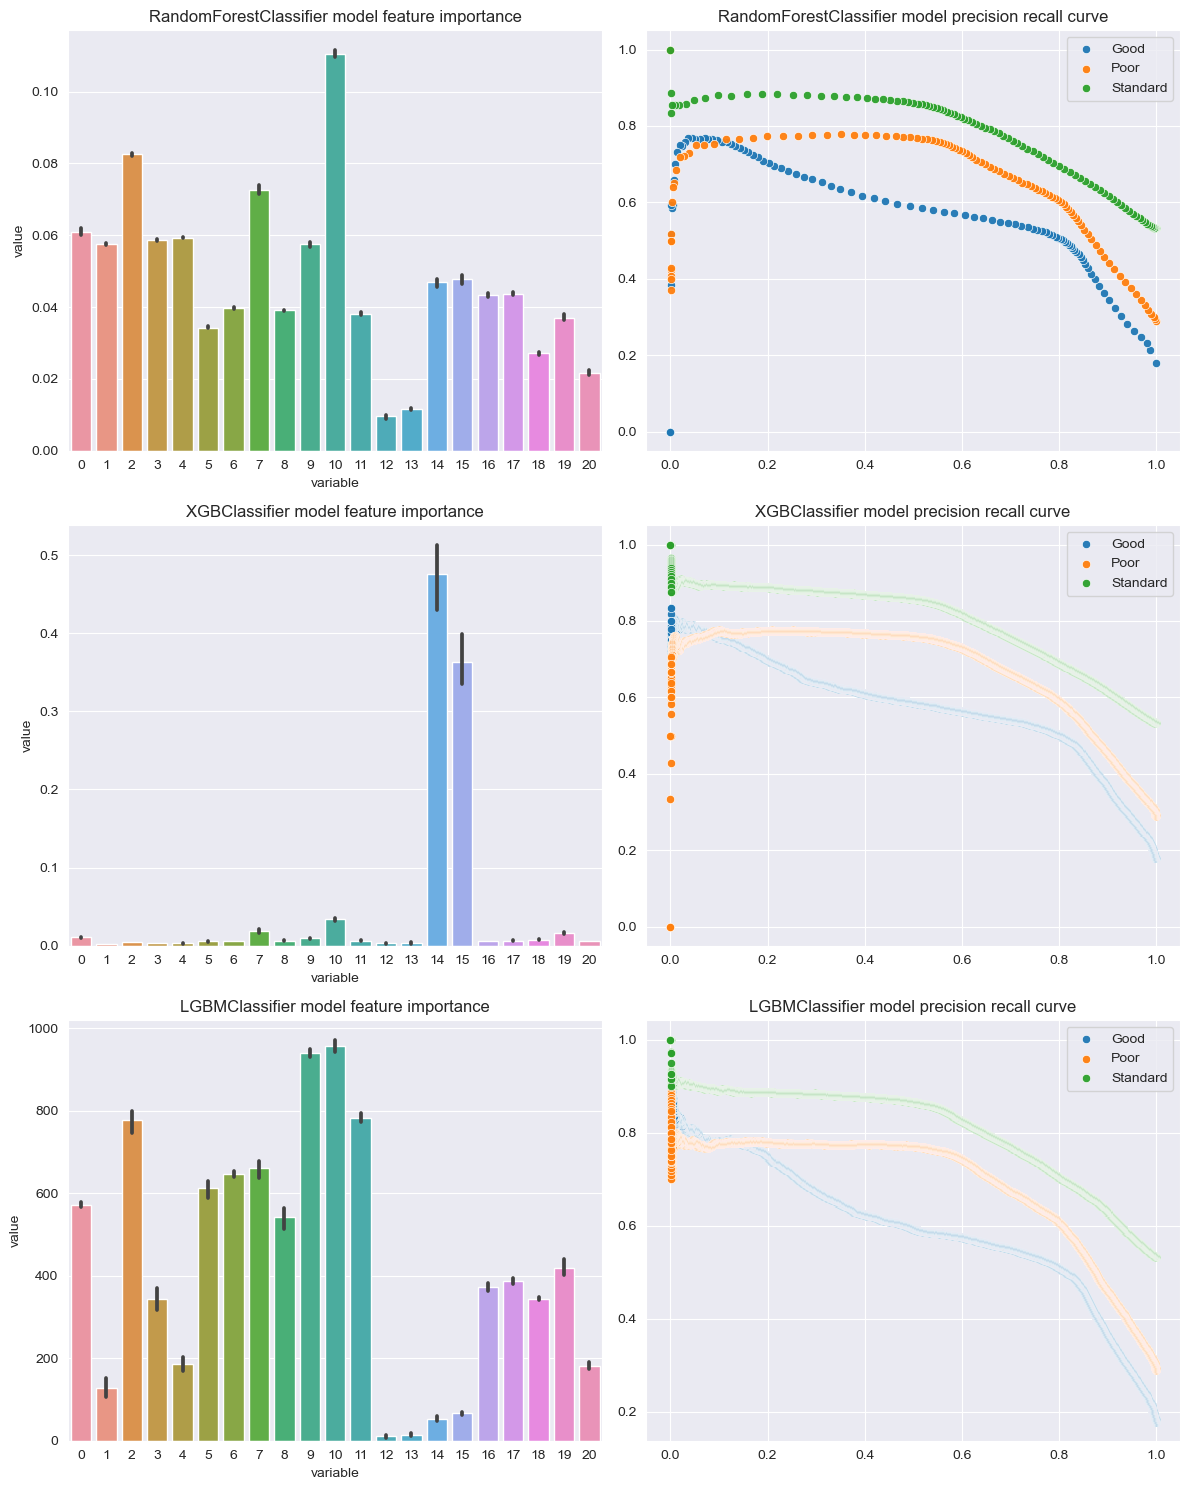

In [62]:
names,models=get_models()
fig,axes=plt.subplots(3,2,figsize=(12,15))
result={}

for i in range(len(models)):
    scores=[]
    importance=[]
    probability=[]
    
    for train_idx,val_idx in StratifiedKFold(n_splits=5).split(X,y):
        model=models[i].fit(X[train_idx,:],y[train_idx])
        y_pred=model.predict(X[val_idx,:])
        y_true=y[val_idx]
        score=f1_score(y_true,y_pred,average='macro')
        
        scores.append(score)
        importance.append(model.feature_importances_)
        probability.append(model.predict_proba(X[val_idx,:]))
        
    ax=axes[i,0]
    frame=pd.DataFrame(importance)
    result_p=pd.melt(frame,value_vars=frame.columns)
    sns.barplot(x="variable",y="value",data=result_p,ax=ax);
    ax.set_title(f"{names[i]} model feature importance")
        
    ax=axes[i,1]
    y_true=label_binarize(y,classes=range(len(label.classes_)))
    y_proba=np.concatenate([probability[j] for j in range(len(probability))])
    for k in range(len(label.classes_)):
        precision,recall,thresh=precision_recall_curve(y_true[:,k],y_proba[:,k])
        sns.scatterplot(recall, precision, alpha=0.95,ax=ax,label=label.classes_[k])
    ax.legend()
    ax.set_title(f"{names[i]} model precision recall curve")
            
    plt.tight_layout()
    result[names[i]]=scores
    
plt.savefig("image8.png")

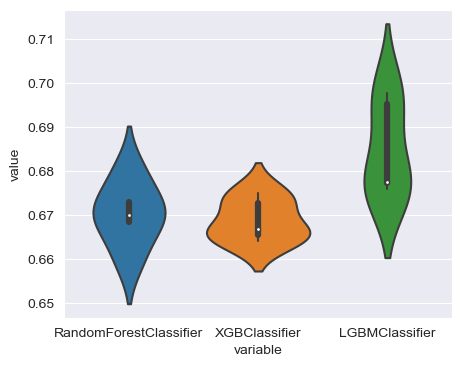

In [67]:
plt.figure(figsize=(5,4))
frame=pd.DataFrame(result)
result_p=pd.melt(frame,value_vars=frame.columns)
sns.violinplot(x="variable",y="value",data=result_p);
plt.savefig("image9.png")

# LGBM Classifier

In [68]:
def objective(trial):
    
    params={"n_estimators":trial.suggest_int("n_estimators",100,400),
            "max_depth":trial.suggest_int("max_depth",3,8),
            "learning_rate":trial.suggest_float("learning_rate", 0.01, 0.1,log=True),
            "subsample":trial.suggest_float("subsample",0.2,0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree",0.2,0.8),
            "reg_lambda":trial.suggest_float("reg_lambda", 0.01, 0.1,log=True)}
    
    model=LGBMClassifier(**params,random_state=42,n_jobs=-1)
    cv=StratifiedKFold(n_splits=5)
    scores=cross_val_score(model,X,y,scoring="f1_macro",cv=cv,n_jobs=-1)
    trial.set_user_attr("f1_macro", scores.mean())
    
    return scores.mean()

In [ ]:
study = optuna.create_study(study_name="Hyperparameter optimization",direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20,show_progress_bar=True)


In [71]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier
from joblib import parallel_backend

# Objective function for optimization
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 0.1),
    }

    # Initialize the model with hyperparameters
    model = LGBMClassifier(**params, random_state=42, n_jobs=-1)

    # Create a stratified K-fold cross-validator
    cv = StratifiedKFold(n_splits=5)

    # Use threading as backend to avoid parallelism issues
    with parallel_backend('threading'):
        scores = cross_val_score(model, X, y, scoring="f1_macro", cv=cv, n_jobs=-1)
    
    # Set user attribute to track F1 score
    trial.set_user_attr("f1_macro", scores.mean())
    return scores.mean()

# Create the Optuna study
study = optuna.create_study(study_name="Hyperparameter optimization", direction="maximize", 
                            sampler=optuna.samplers.TPESampler(seed=42))

# Run the optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)


[I 2024-09-26 20:51:19,826] A new study created in memory with name: Hyperparameter optimization


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-09-26 20:51:29,889] Trial 0 finished with value: 0.6797586136949173 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.07587945476302646, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.40921304830970556, 'reg_lambda': 0.02403950683025824}. Best is trial 0 with value: 0.6797586136949173.
[I 2024-09-26 20:51:35,460] Trial 1 finished with value: 0.6841687466243705 and parameters: {'n_estimators': 123, 'max_depth': 9, 'learning_rate': 0.0641003510568888, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.3144091460070617, 'reg_lambda': 0.0972918866945795}. Best is trial 1 with value: 0.6841687466243705.
[I 2024-09-26 20:51:51,893] Trial 2 finished with value: 0.6879678786009211 and parameters: {'n_estimators': 433, 'max_depth': 4, 'learning_rate': 0.02636424704863906, 'subsample': 0.5917022549267169, 'colsample_bytree': 0.5129695700716763, 'reg_lambda': 0.05722807884690141}. Best is trial 2 with value: 0.6879678786009211.
[I 2024-09-26 20:52:06,21

In [72]:
print(f"Best value: {study.best_trial.value}")
print(f"Best hyperparameters:\n {json.dumps(study.best_trial.params, indent=2)}")

Best value: 0.6912518459663223
Best hyperparameters:
 {
  "n_estimators": 151,
  "max_depth": 5,
  "learning_rate": 0.0203699026676352,
  "subsample": 0.8035822679799838,
  "colsample_bytree": 0.8868666733812018,
  "reg_lambda": 0.029718481538313506
}


In [73]:
plot_optimization_history(study)

In [74]:
params=["n_estimators","max_depth","learning_rate","colsample_bytree"]
plot_parallel_coordinate(study,params=params)
plt.savefig("image11.png")

<Figure size 640x480 with 0 Axes>

# XGBoost Classifier

In [75]:
def objective(trial):
    
    params={"n_estimators":trial.suggest_int("n_estimators",100,400),
            "max_depth":trial.suggest_int("max_depth",3,8),
            "learning_rate":trial.suggest_float("learning_rate", 0.01, 0.1,log=True),
            "subsample":trial.suggest_float("subsample",0.2,0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree",0.2,0.8),
            "reg_lambda":trial.suggest_float("reg_lambda", 0.01, 0.1,log=True)}
    
    model=XGBClassifier(**params,random_state=42,n_jobs=-1)
    cv=StratifiedKFold(n_splits=5)
    scores=cross_val_score(model,X,y,scoring="f1_macro",cv=cv,n_jobs=-1)
    trial.set_user_attr("f1_macro", scores.mean())
    
    return scores.mean()

In [77]:
# Objective function for optimization
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 0.1),
    }

    # Initialize the model with hyperparameters
    model = LGBMClassifier(**params, random_state=42, n_jobs=1)  # Set n_jobs=1 to avoid parallelism issues

    # Create a stratified K-fold cross-validator
    cv = StratifiedKFold(n_splits=5)

    # Run cross-validation without parallelism
    scores = cross_val_score(model, X, y, scoring="f1_macro", cv=cv, n_jobs=1)  # n_jobs=1 to avoid pickling issues
    
    # Set user attribute to track F1 score
    trial.set_user_attr("f1_macro", scores.mean())
    return scores.mean()

# Create the Optuna study
study = optuna.create_study(study_name="Hyperparameter optimization", direction="maximize", 
                            sampler=optuna.samplers.TPESampler(seed=42))

# Run the optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)


[I 2024-09-26 21:08:08,961] A new study created in memory with name: Hyperparameter optimization


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 79968, number of used features: 21
[LightGBM] [Info] Start training from score -1.724308
[LightGBM] [Info] Start training from score -1.237862
[LightGBM] [Info] Start training from score -0.631676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2532
[LightGBM] [Info] Number of data points in the train set: 79968, number of used features: 21
[LightGBM] [Info] Start training from score -1.724308
[LightGBM] [Info] Start training from score -1.237862
[LightGBM] [Info] Start 

In [78]:
print(f"Best value: {study.best_trial.value}")
print(f"Best hyperparameters:\n {json.dumps(study.best_trial.params, indent=2)}")

Best value: 0.6912518459663223
Best hyperparameters:
 {
  "n_estimators": 151,
  "max_depth": 5,
  "learning_rate": 0.0203699026676352,
  "subsample": 0.8035822679799838,
  "colsample_bytree": 0.8868666733812018,
  "reg_lambda": 0.029718481538313506
}


In [79]:
plot_optimization_history(study)

In [80]:
plot_param_importances(study)
plt.savefig("image12.png")

<Figure size 640x480 with 0 Axes>

In [81]:
params=["n_estimators","max_depth","colsample_bytree"]
plot_parallel_coordinate(study,params=params)
plt.savefig("image13.png")

<Figure size 640x480 with 0 Axes>

# Random Forest Classifier

In [82]:
def objective(trial):
    
    params={"n_estimators":trial.suggest_int("n_estimators",100,400),
            "max_depth":trial.suggest_int("max_depth",3,8),
            "max_samples":trial.suggest_float("max_samples",0.2,0.8),
            "min_samples_split": trial.suggest_int("min_samples_split",2,20),
            "max_features":trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"])}
    
    model=RandomForestClassifier(**params,random_state=42,n_jobs=-1)
    cv=StratifiedKFold(n_splits=5)
    scores=cross_val_score(model,X,y,scoring="f1_macro",cv=cv,n_jobs=-1)
    trial.set_user_attr("f1_macro", scores.mean())
    
    return scores.mean()

In [84]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from joblib import parallel_backend
import pickle

# Objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)

    # Ensure the model is picklable
    try:
        pickle.dumps(model)
    except pickle.PicklingError as e:
        print(f"PicklingError: {e}")
        return None

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5)

    # Parallel backend for joblib to avoid serialization issues
    with parallel_backend('threading'):
        scores = cross_val_score(model, X, y, scoring="f1_macro", cv=cv, n_jobs=-1)

    # Return the average F1 macro score
    return scores.mean()

# Optuna study
study = optuna.create_study(study_name="Hyperparameter optimization", direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=42))

# Optimize the study
study.optimize(objective, n_trials=20, show_progress_bar=True)


[I 2024-09-26 21:25:49,035] A new study created in memory with name: Hyperparameter optimization


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-09-26 21:28:08,234] Trial 0 finished with value: 0.6803578724516164 and parameters: {'n_estimators': 437, 'max_depth': 28, 'max_samples': 0.7587945476302645, 'min_samples_split': 13, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6803578724516164.
[I 2024-09-26 21:30:37,595] Trial 1 finished with value: 0.6919171137097428 and parameters: {'n_estimators': 880, 'max_depth': 10, 'max_samples': 0.737265320016441, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6919171137097428.
[I 2024-09-26 21:31:18,992] Trial 2 finished with value: 0.6739446137790562 and parameters: {'n_estimators': 263, 'max_depth': 3, 'max_samples': 0.373818018663584, 'min_samples_split': 11, 'max_features': None}. Best is trial 1 with value: 0.6919171137097428.
[I 2024-09-26 21:31:34,397] Trial 3 finished with value: 0.6616137818308128 and parameters: {'n_estimators': 225, 'max_depth': 4, 'max_samples': 0.4297256589643226, 'min_samples_split': 10, 'max_features': 'sqrt'}.

In [85]:
print(f"Best value: {study.best_trial.value}")
print(f"Best hyperparameters:\n {json.dumps(study.best_trial.params, indent=2)}")

Best value: 0.6919171137097428
Best hyperparameters:
 {
  "n_estimators": 880,
  "max_depth": 10,
  "max_samples": 0.737265320016441,
  "min_samples_split": 2,
  "max_features": "sqrt"
}


In [86]:
plot_optimization_history(study)

In [87]:
plot_param_importances(study)
plt.savefig("image14.png")

<Figure size 640x480 with 0 Axes>

In [88]:
params=["max_depth", "max_samples", "min_samples_split"]
plot_parallel_coordinate(study,params=params)
plt.savefig("image15.png")

<Figure size 640x480 with 0 Axes>

# Ensemble of Models

In [89]:
lgbm_params={"n_estimators": 319,
             "max_depth": 5,
             "learning_rate": 0.01007506187129231,
             "subsample": 0.7243746196920224,
             "colsample_bytree": 0.6043128820104816,
             "reg_lambda": 0.010068213652019799 }

xgb_params={"n_estimators": 319,
            "max_depth": 5,
            "learning_rate": 0.010320226911021985,
            "subsample": 0.41644521272647506,
            "colsample_bytree": 0.6465159042623695,
            "reg_lambda": 0.04479410490748427 }

rf_params={"n_estimators": 212,
           "max_depth": 8,
           "max_samples": 0.6391963650868431,
           "min_samples_split": 13,
           "max_features": "auto"}

In [90]:
models={"LGBMClassifier":LGBMClassifier(**lgbm_params,random_state=42,n_jobs=-1),
        "XGBClassifier":XGBClassifier(**xgb_params,random_state=42,n_jobs=-1),
        "RandomForestClassifier":RandomForestClassifier(**rf_params,random_state=42,n_jobs=-1)}

In [91]:
probability=dict(zip(models.keys(),[[] for _ in range(len(models.keys()))]))

for train_idx,val_idx in StratifiedKFold(n_splits=5).split(X,y):
    X_train,y_train=X[train_idx,:],y[train_idx]
    X_val,y_val=X[val_idx,:],y[val_idx]
    for name,model in models.items():
        algo=model.fit(X_train,y_train)
        y_proba=algo.predict_proba(X[val_idx,:])
        probability[name].append(algo.predict_proba(X[val_idx,:]))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 79968, number of used features: 21
[LightGBM] [Info] Start training from score -1.724308
[LightGBM] [Info] Start training from score -1.237862
[LightGBM] [Info] Start training from score -0.631676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [92]:
inter=probability.copy()

In [93]:
y_true=label_binarize(y,classes=range(len(label.classes_)))
probas=dict(zip(models.keys(),[[] for _ in range(len(models.keys()))]))
for name in models.keys():
    proba=np.concatenate([probability[name][i] for i in range(len(probability[name]))])
    probas[name].append(proba)

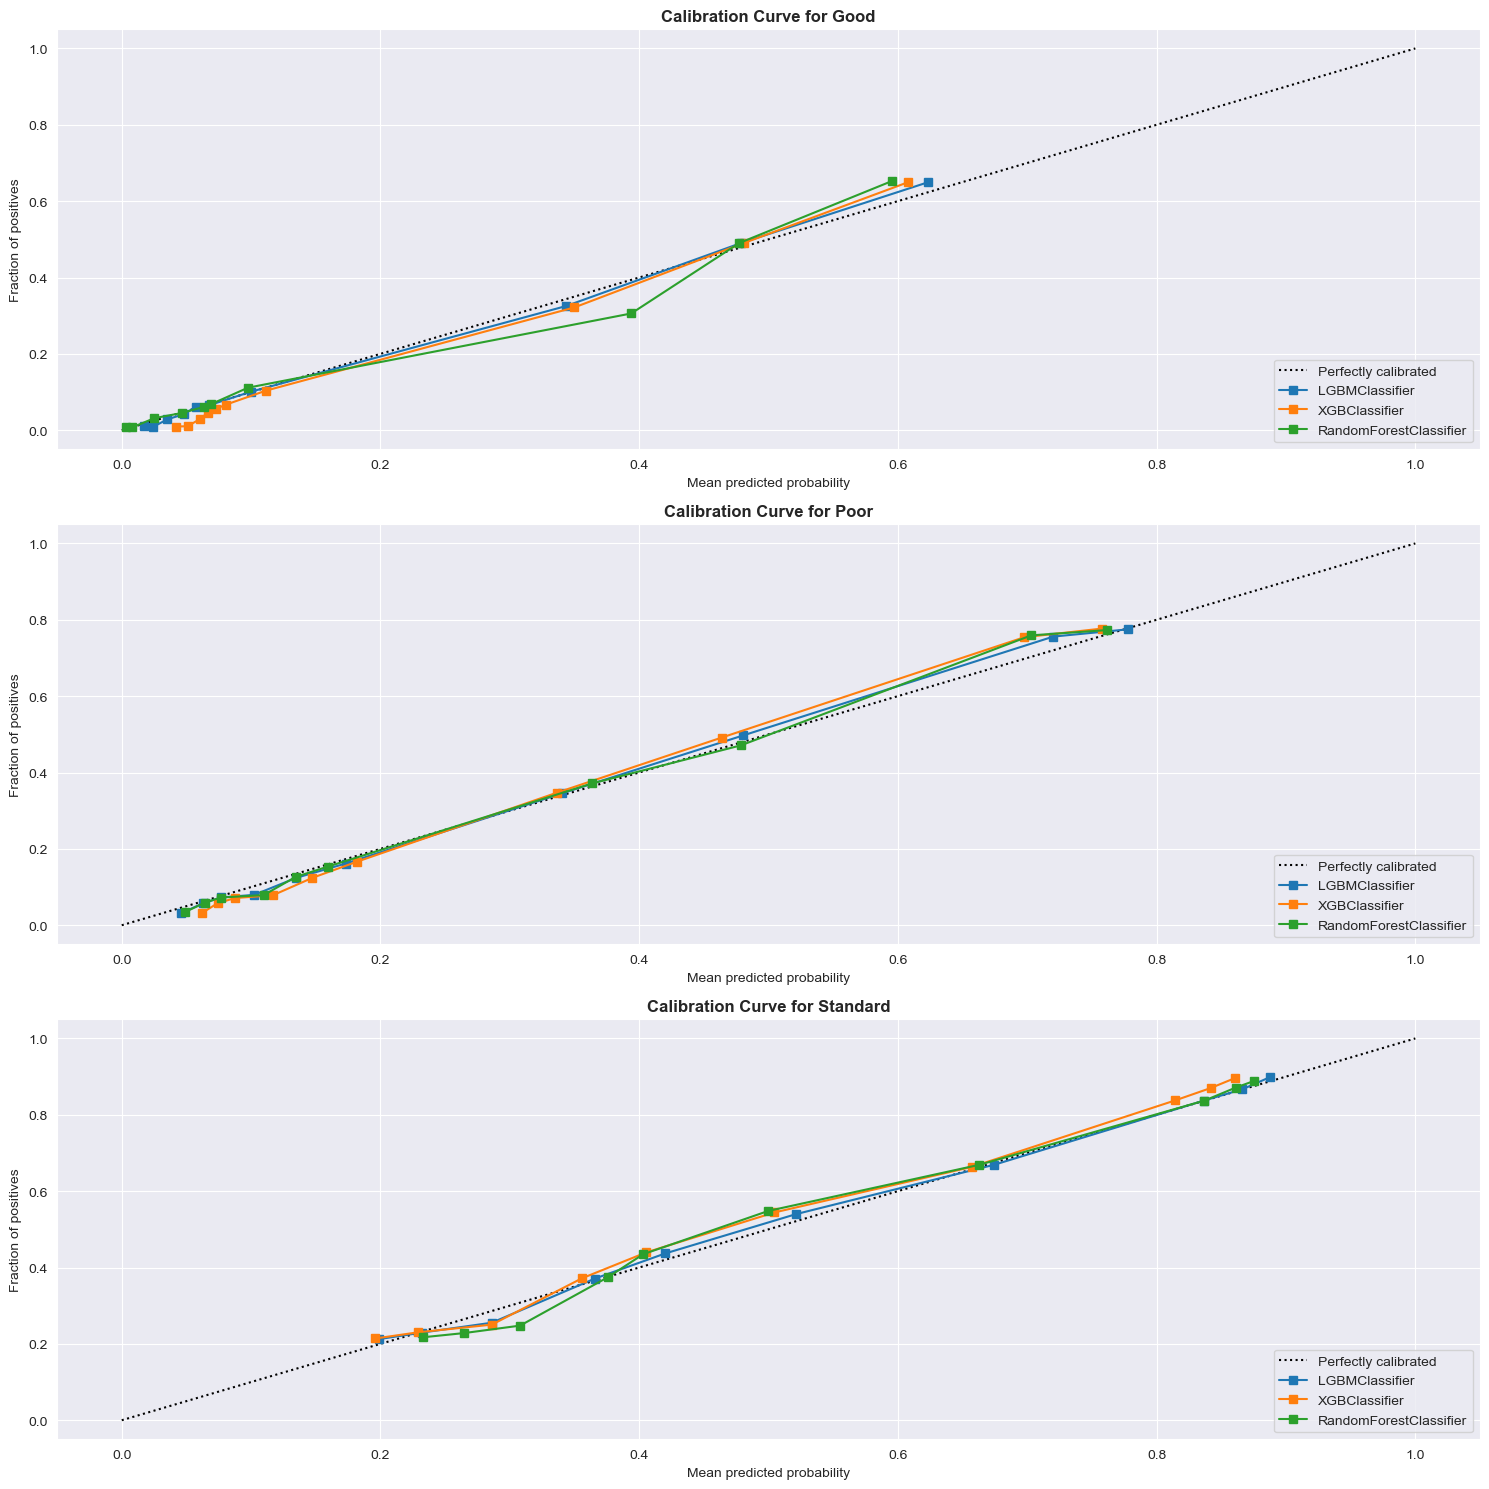

In [94]:
fig,axes=plt.subplots(3,1,figsize=(15,15))
ax=axes.flatten()

for i,classes in enumerate(list(label.classes_)):
    ax[i].set_title(f"Calibration Curve for {classes}",fontweight="bold")
    for name,prediction in probas.items():
        y_real=y_true[:,i]
        y_prob=probas[name][0][:,i]
        CalibrationDisplay.from_predictions(y_real,y_prob,n_bins=10, strategy='quantile',ax=ax[i],name=name);
        
plt.tight_layout()
plt.savefig("image16.png")

#### The probabilities predicted by the models for each class in target variable is well calibrated. Therefore there is no need to calibrate the predicted probabailities.

In [95]:
probas["Average_Models"]=[np.add(probas["LGBMClassifier"][0],probas["XGBClassifier"][0])]
probas["Average_Models"]=[np.add(probas["Average_Models"][0],probas["RandomForestClassifier"][0])/3]

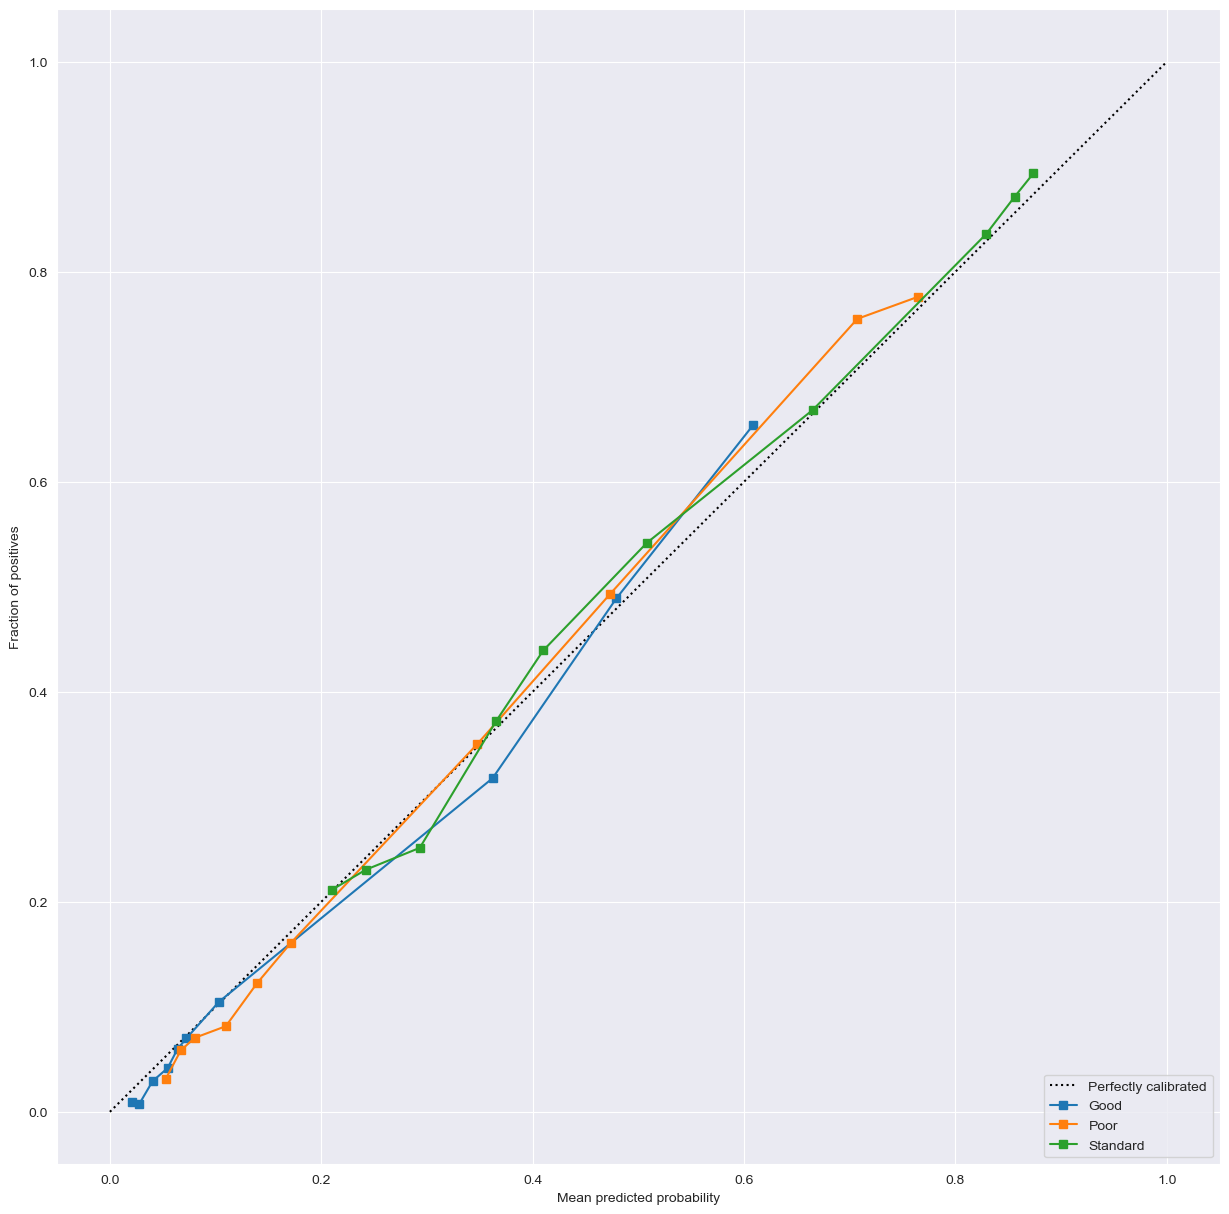

In [96]:
plt.figure(figsize=(15,15))
axes=plt.subplot(1,1,1)

for i,classes in enumerate(list(label.classes_)):
    y_real=y_true[:,i]
    y_prob=probas["Average_Models"][0][:,i]
    CalibrationDisplay.from_predictions(y_real,y_prob,n_bins=10, strategy='quantile',name=classes,ax=axes);
plt.savefig("image17.png")

In [97]:
for models in probas.keys():
    sol=np.argmax(probas[models][0],axis=1)
    score=f1_score(y,sol,average="macro")
    print(f"\n{models} f1 score is: {score}")


LGBMClassifier f1 score is: 0.679541436764899

XGBClassifier f1 score is: 0.679332553299829

RandomForestClassifier f1 score is: 0.6778430059906345

Average_Models f1 score is: 0.6798862351013816


#### The ensemble of model performed better than individual model, we can also try weights ensemble and stacking. Plus data oversampling of minority instances classes and undersampling of overlapping instances using imblearn library.

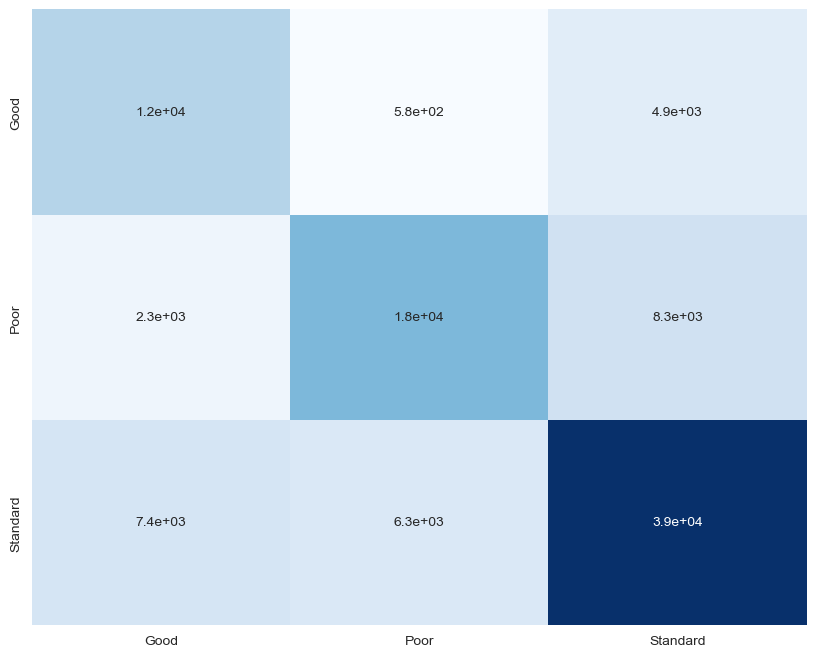

In [98]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y,sol),annot=True,cbar=False,xticklabels=label.classes_,yticklabels=label.classes_,cmap="Blues");
plt.savefig("image18.png")

In [99]:
print(classification_report(y,sol))

              precision    recall  f1-score   support

           0       0.56      0.69      0.62     17823
           1       0.73      0.63      0.68     28988
           2       0.75      0.74      0.75     53149

    accuracy                           0.70     99960
   macro avg       0.68      0.69      0.68     99960
weighted avg       0.71      0.70      0.70     99960

